# (E11) 프로젝트: 뉴스기사 요약해보기

- 뉴스 기사의 텍스트 데이터를 불러와 요약하여 헤드라인을 만들어주는 프로젝트입니다.
- 요약 방법에는 추상적 요약 방법과 추출적 요약 방법이 있습니다.
- seq2seq의 성능을 높이기 위해 Attention Mechanism을 사용합니다.

## Attention Mechanism이란?

- Attention Mechanism은 기존의 RNN 모델인 seq2seq를 개선하기 나온 모델입니다.
- seq2seq의 한계는 큰 데이터가 들어올 경우 압축하는 과정에서 encoder에서 정보 손실이 발생하는데, RNN 구조의 마지막의 출력 결과를 사용하는 것이 아니라 모든 출력을 사용합니다.
- 모든 출력을 사용할 때 중요도를 고려하여 단어에 주목하게 하는데 이 방법이 Attention입니다.

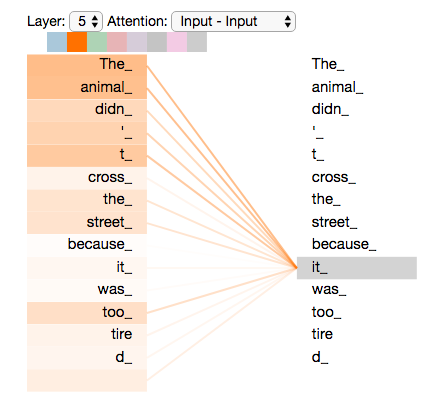

In [56]:
from IPython.display import Image
Image("../Desktop/transformer_self-attention_visualization.png")
# (출처)http://jalammar.github.io/illustrated-transformer/ 

## Import Libraries

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj22/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Load Data

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98401


In [4]:
data.sample(10)

,headlines,text
40400,SEBI imposes Ã¢ÂÂ¹10 lakh fine on DLF over wr...,Markets regulator SEBI has imposed a fine of Ã...
98204,Indian-American sworn-in as top US healthcare ...,US President Donald Trump's pick Seema Verma w...
73693,Malvika who played young Poo in K3G to star in...,"Malvika Raaj, known for playing the younger ve..."
57711,In 2 or 3 yrs weÃ¢ÂÂll have first flying tax...,Volocopter's Co-founder Alex Zosel has said th...
72673,Google CEO shoots for SRK's TED Talks via tele...,Google CEO Sundar Pichai has shot for an episo...
62282,I am a product of two amazing American things:...,Microsoft's India-born CEO Satya Nadella has s...
16676,1 road in each UP urban local body to be named...,Uttar Pradesh CM Yogi Adityanath has announced...
83529,Goibibo delists hotel that denied room to 'sin...,Travel booking platform Goibibo has delisted t...
80504,Another suspicious packet of powder found insi...,After an explosive substance was found inside ...
65493,"KRK trolled for saying Kohli ended Yuvraj, Rai...",Self-styled critic Kamaal R Khan was trolled o...


## 2. 데이터 전처리

## 2.1 중복 제거

In [5]:
# 중복 샘플 유무 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
# 중복 제거
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [7]:
# Null 값 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


Null 값이 존재하지 않으므로 Null 값을 제거할 필요가 없습니다.

## 2.2 텍스트 정규화

같은 의미의 중복된 표현을 제거하는 것을 텍스트 정규화라고 합니다.

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


## 2.3 불용어 제거

학습에 실질적으로 도움되지 않는 단어인 불용어를 확인하고 이를 제거합니다.

In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [10]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
# 훈련 데이터 전처리, 불용어 제거
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [12]:
# test 데이터 전처리, 불용어 제거 안 함
clean_summary = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [13]:
# empty 샘플 확인
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [14]:
# Null 값 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

- 텍스트 정제의 과정을 거쳐 빈 값을 가지는 경우도 있어 다시 한 번 확인합니다.
- Null 값이 존재하지 않으므로 Null 값을 제거할 필요가 없습니다.

## 2.4 샘플 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


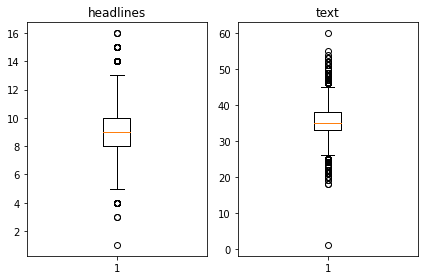

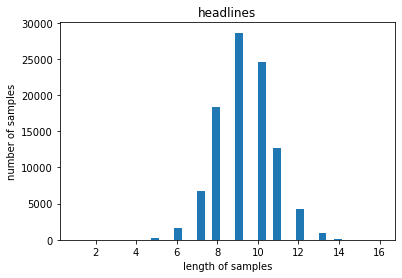

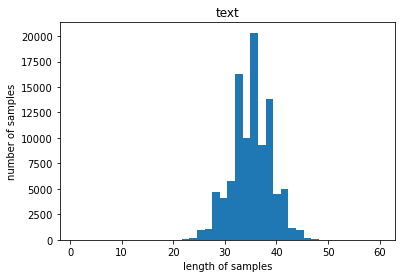

In [15]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
text_max_len = 40
summary_max_len = 12

In [17]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [19]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 89775


## 2.5 시작 토큰과 종료 토큰 추가

- 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈춥니다.
- seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있습니다.
- 시작 토큰은 'sostoken', 종료 토큰은 'eostoken'이라 임의로 명명하고 앞, 뒤로 추가합니다.

In [20]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [21]:
# 인코더의 입력, 디코더의 입력과 레이블 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

## 2.6 훈련 데이터와 테스트 테이터 분리

- 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리합니다. 
- 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의하겠습니다.

In [22]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[71956 72966 59502 ... 43905 11029 52553]


In [23]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [24]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 17955


In [25]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 71820
훈련 레이블의 개수 : 71820
테스트 데이터의 개수 : 17955
테스트 레이블의 개수 : 17955


## 2.7 단어 집합(vocaburary) 만들기

- 텍스트를 숫자로 처리할 수 있도록 데이터의 훈련 데이터와 테스트 데이터의 단어들을 정수로 바꾸는 작업을 합니다.
- 각 단어에 고유한 정수를 맵핑하는 것을 단어 집합을 만든다고 합니다.

In [26]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [27]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 65678
등장 빈도가 6번 이하인 희귀 단어의 수: 44716
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20962
단어 집합에서 희귀 단어의 비율: 68.08368098906787
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.6644805304808696


- 등장 빈도가 threshold 값인 7회 미만, 즉, 6회 이하인 단어들은 단어 집합에서 68% 이상을 차지합니다.
- 그러나 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.66%밖에 되지 않습니다.
- 따라서 단어 집합의 크기를 20000으로 제한하여 학습에 도움을 줍니다.

In [28]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [29]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[26, 8, 22, 560, 677, 2461, 354, 776, 5636, 158, 398, 736, 1149, 5636, 46, 313, 200, 414, 99, 5022, 158, 23, 414, 6390, 745, 156, 125, 1188, 1630, 220, 83], [9627, 488, 1199, 78, 1022, 678, 105, 1, 66, 54, 2346, 44, 3660, 394, 1199, 3525, 863, 4947, 1048, 3, 9627, 1, 292, 1195, 111, 2066, 9835, 3748], [2253, 530, 102, 156, 17, 4, 16438, 1252, 9226, 73, 8546, 479, 530, 430, 9, 101, 5907, 12, 851, 447, 411, 145, 1, 22, 1252, 9226, 819, 932, 679, 466, 2902, 137, 538]]


In [30]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [31]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28842
등장 빈도가 5번 이하인 희귀 단어의 수: 18947
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9895
단어 집합에서 희귀 단어의 비율: 65.6923930379308
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.928597324758948


- 등장 빈도가 threshold 값인 6회 미만, 즉, 5회 이하인 단어들은 단어 집합에서 65% 이상을 차지합니다.
- 그러나 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 4.89%밖에 되지 않습니다.
- 따라서 단어 집합의 크기를 9900으로 제한하여 학습에 도움을 줍니다.

In [32]:
tar_vocab = 9900
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 26, 2180, 89, 532, 6444, 3, 182, 1372], [1, 2760, 74, 28, 1510, 5, 570, 258, 452], [1, 54, 7257, 482, 1049, 3, 21, 4, 36], [1, 1668, 925, 51, 14, 6, 680, 377, 4, 1776], [1, 255, 863, 4120, 2652, 3, 686, 446, 12, 54]]
target
decoder  [[26, 2180, 89, 532, 6444, 3, 182, 1372, 2], [2760, 74, 28, 1510, 5, 570, 258, 452, 2], [54, 7257, 482, 1049, 3, 21, 4, 36, 2], [1668, 925, 51, 14, 6, 680, 377, 4, 1776, 2], [255, 863, 4120, 2652, 3, 686, 446, 12, 54, 2]]


In [33]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 71820
훈련 레이블의 개수 : 71820
테스트 데이터의 개수 : 17955
테스트 레이블의 개수 : 17955


/home/aiffel-dj22/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## 2.8 패딩

In [34]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

## 3. 어텐션 메커니즘

## 3.1 모델 설계

In [35]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [36]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [37]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 3.2 어텐션 메커니즘

In [38]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [39]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 3.3 모델 훈련

In [40]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
281/281 [==============================] - 106s 376ms/step - loss: 5.6519 - val_loss: 5.2187
Epoch 2/50
281/281 [==============================] - 103s 368ms/step - loss: 5.1058 - val_loss: 4.8653
Epoch 3/50
281/281 [==============================] - 101s 360ms/step - loss: 4.7643 - val_loss: 4.5928
Epoch 4/50
281/281 [==============================] - 103s 365ms/step - loss: 4.5009 - val_loss: 4.4099
Epoch 5/50
281/281 [==============================] - 99s 352ms/step - loss: 4.2950 - val_loss: 4.2605
Epoch 6/50
281/281 [==============================] - 103s 366ms/step - loss: 4.1206 - val_loss: 4.1483
Epoch 7/50
281/281 [==============================] - 103s 366ms/step - loss: 3.9693 - val_loss: 4.0590
Epoch 8/50
281/281 [==============================] - 101s 358ms/step - loss: 3.8423 - val_loss: 3.9828
Epoch 9/50
281/281 [==============================] - 102s 365ms/step - loss: 3.7295 - val_loss: 3.9312
Epoch 10/50
281/281 [==============================] - 106s 377ms

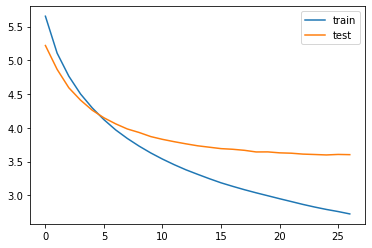

In [41]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [42]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [43]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [44]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [45]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 4. 실제 결과와 요약문 비교

## 모델 테스트

In [46]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [47]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : congress leader digvijaya singh indian express idea exchange said complaint party vice president rahul gandhi acting told number times sometimes gets angry keep repeating thing said digvijaya person rebuild congress better rahul added 
실제 요약 : rahul gandhi not acting digvijaya singh 
예측 요약 :  rahul gandhi is the new word of the new leader


원문 : uidai announced phased rollout face recognition feature additional authentication mode starting telecom operators september matching live face photo photo essential cases aadhaar used issuing uidai earlier planned roll feature july target later pushed august 
실제 요약 : rollout of face authentication from sept uidai 
예측 요약 :  govt to allow aadhaar to check online using aadhaar


원문 : pakistani pacer wahab riaz claimed pakistan make plans tackle indian captain virat kohli world cup praising kohli riaz added indian team good batsmen virat kohli doubt one best going around right riaz last played odi pakistan champions trophy 
실제 요약 : pak will ma

예측 요약 :  wikileaks sued over wikileaks wikileaks wikileaks


원문 : social media giant facebook topped list best tech companies work us according technology giant google ranked number list microsoft ranked facebook also topped list average span employee retention years according career advisory firm 
실제 요약 : facebook top tech company to work for in us in 
예측 요약 :  facebook named most indian company in india


원문 : defence minister nirmala sitharaman assured people army defence ministry protect external threats assure people india defence ministry soldiers completely prepared citizens live peacefully families said added defence home ministry closely monitoring ceasefire violations across loc 
실제 요약 : army capable of giving peaceful lives to citizens min 
예측 요약 :  will not allow troops to army forces to enter army chief


원문 : slamming congress president rahul gandhi bjp cell chief amit malviya claimed gandhi twitter profile added gandhi growing quality tweets public appearances alleging b

예측 요약 :  us to russia embassy in russia over spying


원문 : wreckage russian warship believed carrying gold worth billion found south korean island warship russo japanese war firm discovered ship said raise vessel later year give half gold found aboard russian government 
실제 요약 : of russian ship with bn gold found in korea 
예측 요약 :  gold worth crore seized in japan


원문 : punjabi singer gill said actress sonakshi sinha changed perception stars bollywood adding realised bigger star humble earth thoroughly enjoyed working sonakshi said making bollywood acting debut sonakshi starrer happy bhag jayegi 
실제 요약 : sonakshi changed my of big stars in wood 
예측 요약 :  not to be called in music in wood show lata


원문 : yoga guru baba ramdev monday said caste system rooted holistic development country stating hindu religious texts endorse caste based discrimination ramdev added people misinterpreted vedas without studying religions across world equal added 
실제 요약 : caste system is should be out ramde

## 5. Summa을 이용해서 추출적 요약

In [48]:
import requests
from summa.summarizer import summarize

In [49]:
summa_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [52]:
for i in range(50, 100):
    print("원문 :", summa_data['text'][i])
    print("실제 요약 :", summa_data['headlines'][i])
    print("예측 요약 :", summarize(summa_data['text'][i], words=15))
    print("\n")

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL
예측 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight

예측 요약 : Airtel Africa, the holding company for Airtel's operations in 14 African countries, is preparing for an initial public offering.


원문 : Actor Shreyas Talpade said that 'Golmaal' filmmaker Rohit Shetty is still working on the script for the fifth instalment of the 'Golmaal' film franchise. "He was telling us the other day that he...cracked some story. Once he's done with the...scripting, he'll take a call,Ã¢ÂÂ the actor added. The series features Shreyas along with Ajay Devgn, Arshad Warsi and Tusshar Kapoor.
실제 요약 : Rohit Shetty still working on script for Golmaal 5: Shreyas
예측 요약 : Actor Shreyas Talpade said that 'Golmaal' filmmaker Rohit Shetty is still working on the script for the fifth instalment of the 'Golmaal' film franchise.


원문 : A 72-year-old man named Terry Sanderson has sued 'Avengers' actress Gwyneth Paltrow for allegedly crashing into him while skiing, and is seeking $3.1 million (over Ã¢ÂÂ¹22 crore) in damages. The lawsuit states the actress got up and skied

## 회고

- 이전에는 loss 그래프를 보고 overfitting 구간을 확인하는 불편함이 있었지만, Early Stopping method를 사용하면 모델이 학습을 스스로 종료할 수 있는 이점이 있다. 더 이상 진행하지 않아도 되는 학습을 중지시켜서 학습 시간을 단축시키고 overfitting을 방지할 수 있어서 편리한 method다. 
- 어텐션을 이용하여 추상적 요약을 진행하였는데 어색한 문장이 많지만, 지금의 결과로도 높은 성능을 내는 것이 대단하게 느껴진다. 문장의 길이가 길지 않고 간단한 호불호를 표시하는 문장의 경우에는 어텐션 모델을 통하여 충분히 좋은 결과를 낼 수 있을 거라 생각된다.
- 추출적 요약 방법과 추상적 요약 방법을 비교하면, 추출적 요약 방법은 뉴스 기사 안의 단어를 추출하여 예측을 요약하기 때문에 추상적 요약 방법보다 요약의 문장이 문맥상 잘 전달된다. 추상적 요약 방법 또한 문맥상 의미를 잡아서 예측하는 요약문이 있기는 하지만 성능을 높이면 요약문이 더 매끄러워질 것 같다.
- 추출적 요약의 단점은 예측 요약을 빈 리스트로 반환하는 경우도 있다. 일정 ratio나 words보다 작은 경우 토큰화 과정 속에서 만들어진 단어 집합에서 예측 요약문을 생성하지 못한다.